In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab-AILAB/LAB1

/content/drive/MyDrive/Colab-AILAB/LAB1


In [3]:
import os
from typing import Callable, Iterable
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [4]:
class Parameter:
    def __init__(self, data: np.ndarray) -> None:
        self.data = data #存放參數
        self.grad = None #存放Gradient


class Module:
    def __call__(self, *args, **kwargs) -> np.ndarray:
        return self.forward(*args, **kwargs)

    def __repr__(self) -> str:
        layers = '\n'.join([f'  ({k}): {v}' for k, v in self.__dict__.items()])
        return f'{self.__class__.__name__}(\n{layers}\n)'

In [5]:
## 1. Implement the following layers as Python functions (both forward and backward propagation)
#* Inner-product layer
#* Activation layer(Sigmoid or Rectified)
#* Softmax layer

class Linear(Module):
    def __init__(self, in_features, out_features) -> None:
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Initialize weights and biases
        init_factor = 0.01
        self.W = Parameter(np.random.randn(in_features, out_features) * init_factor)
        self.b = Parameter(np.zeros((1, out_features)))

        # Cache for backward pass
        self.x = None

    def forward(self, x):
        # 學生實作部分：reutrn output of linear layer

        self.x = x
        # 執行矩陣乘法 XW + b
        # x.shape: (N, in_features), W.data.shape: (in_features, out_features)
        # output.shape: (N, out_features)
        output = np.dot(x, self.W.data) + self.b.data # y = wx+b
        return output

    def backward(self, dy):
        # 學生實作部分：return gradient w.r.t. input and compute gradients for weights and biases

        # 計算對權重W的梯度(dL/dW)
        # x.T.shape: (in_features, N), dy.shape: (N, out_features)
        # dW.shape: (in_features, out_features)
        self.W.grad = np.dot(self.x.T, dy)

        # 計算對偏置 b 的梯度 (dL/db)
        # 因為b對於batch中的每個樣本都起作用，所以要將所有樣本的梯度加總
        # dy.shape:(N, out_features)->sum over N (axis=0) -> (1, out_features)
        self.b.grad = np.sum(dy, axis=0, keepdims=True)

        # 計算要傳回給前一層的梯度 (dL/dX)
        # 為了維度，我們需要使用W的轉置
        # dy.shape: (N, out_features), W.data.T.shape: (out_features, in_features)
        # dx.shape: (N, in_features)
        dx = np.dot(dy, self.W.data.T)

        return dx

    def parameters(self):
        return self.W, self.b

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(in_features={self.in_features}, out_features={self.out_features})'


class ReLU(Module):
    def __init__(self) -> None:
        super().__init__()
        self.x = None

    def forward(self, x):
        # 學生實作部分：return output of ReLU activation
        self.x = x
        return np.maximum(0, x) # max(0,x)

    def backward(self, dy):
        # 學生實作部分：return gradient w.r.t. input

        mask = (self.x > 0) # 建立一個mask
        # 將 dy 與遮罩相乘，只保留x>0的地方的梯度
        return dy * mask

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


class Sigmoid(Module):
    def __init__(self) -> None:
        super().__init__()
        self.y = None

    def forward(self, x):
        # 學生實作部分：return output of Sigmoid activation
        # 計算 sigmoid 函數
        y = 1 / (1 + np.exp(-x))
        # 儲存輸出 y，因為 backward 的公式會直接用到它，這樣更有效率
        self.y = y
        return y

    def backward(self, dy):
        # 學生實作部分：return gradient w.r.t. input
        # Sigmoid 的導數是 y * (1 - y)
        # 鏈式法則: dL/dx = (dL/dy) * (dy/dx)
        return dy * self.y * (1 - self.y)

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


class Softmax(Module):
    def __init__(self) -> None:
        super().__init__()
        self.y = None

    def forward(self, x):
        # 學生實作部分：return output of Softmax activation
        # 為了數值穩定性，先減去 x 中的最大值，這不會改變 softmax 的結果
        # axis=1 表示沿著每個樣本的特徵維度尋找最大值
        # keepdims=True 確保結果的維度可以和x broadcasting
        x_stable = x - np.max(x, axis=1, keepdims=True)

        # 計算 e 的次方
        exps = np.exp(x_stable)

        # 計算每個樣本的總和
        sum_exps = np.sum(exps, axis=1, keepdims=True)

        # 計算 softmax 結果
        y = exps / sum_exps

        # 儲存輸出，因為計算 Cross-Entropy Loss 時會用到
        self.y = y
        return y

    def backward(self, dy):
        # 這邊我們設定同學們會將Softmax和Cross-Entropy Loss一起使用
        # 因此backward pass根據講義上的說明使用簡化的版本在Cross-Entropy Loss的部分完成
        # 若同學的softmax沒有和Cross-Entropy Loss一起使用，請自行實作完整的backward pass
        return dy

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [6]:
class MLP(Module):
    def __init__(self) -> None:
        # 學生實作部分：design your Model architecture here

        # 定義第一層：一個線性層，輸入維度為 784 (28*28)，輸出維度自訂為 128
        self.fc1 = Linear(in_features=784, out_features=128)

        # 定義活化層：使用我們剛才寫好的 ReLU
        self.activation = ReLU()

        # 定義第二層：一個線性層，輸入維度為上一層的輸出 128，輸出維度為 10 (對應0-9十個數字)
        self.fc2 = Linear(in_features=128, out_features=10)

    def forward(self, x):
        # 學生實作部分：compute forward pass through your model

        # 1. 通過第一層線性層
        x = self.fc1(x) # 輸出維度: (N, 128)

        # 2. 通過 ReLU 活化函數
        x = self.activation(x) # 輸出維度: (N, 128)

        # 3. 通過第二層線性層
        y = self.fc2(x) # 輸出維度: (N, 10)
        return y

    def backward(self, dy):
        # 學生實作部分：compute backward pass through your model

        # 1. 梯度先通過第二層線性層的 backward
        dy = self.fc2.backward(dy) # 輸出梯度維度: (N, 128)

        # 2. 接著通過 ReLU 活化函數的 backward
        dy = self.activation.backward(dy) # 輸出梯度維度: (N, 128)

        # 3. 最後通過第一層線性層的 backward
        dx = self.fc1.backward(dy) # 輸出梯度維度: (N, 784)

        return dx

    def parameters(self):
        return self.fc1.parameters() + self.fc2.parameters()

In [7]:
## 2. Implement training and testing process
## included cross-validation
class MNIST:
    # root請根據你的檔案位置更改
    def __init__(self, root='/content/drive/MyDrive/Colab-AILAB/LAB1', train=True, transform: Callable = None) -> None:
        path = os.path.join(root, 'mnist_train.csv' if train else 'mnist_test.csv')
        self.data = np.loadtxt(path, delimiter=',')
        self.transform = transform
        self.image_size = 28
        self.num_classes = 10
        self.classes = np.arange(self.num_classes)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = (self.data[idx, 0] == self.classes).astype(
            np.float32
        )  # one-hot encoding
        image = (
            self.data[idx, 1:]
            .reshape(self.image_size * self.image_size)
            .astype(np.float32)
        )
        if self.transform:
            image = self.transform(image)
        return image, label


class Subset:
    def __init__(self, dataset, indices: Iterable) -> None:
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]


class DataLoader:
    def __init__(self, dataset, batch_size=1) -> None:
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = np.arange(len(dataset))

    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size

    def __iter__(self):
        for start_idx in range(0, len(self.dataset), self.batch_size):
            end_idx = min(start_idx + self.batch_size, len(self.dataset))
            batch_indices = self.indices[start_idx:end_idx]

            batch_images = []
            batch_labels = []

            for idx in batch_indices:
                image, label = self.dataset[idx]
                batch_images.append(image)
                batch_labels.append(label)

            yield np.array(batch_images), np.array(batch_labels)

In [8]:
# Separate train_imgs, train_labels into training and validation
# root請根據你的檔案位置更改
def load_mnist_data(
    root="/content/drive/MyDrive/Colab-AILAB/LAB1", batch_size=1, split_ratio=0.1, transform=None
) -> tuple[DataLoader, DataLoader, DataLoader]:
    def _split_dataset(dataset, split_ratio):
        # 學生實作部分：split dataset into training and validation sets
        # hint: return Subset(dataset, train_indices), Subset(dataset, valid_indices)

        dataset_size = len(dataset)
        # 產生一個從 0 到 (dataset_size - 1) 的索引列表
        indices = list(range(dataset_size))
        # 計算驗證集的樣本數量
        split_point = int(np.floor(split_ratio * dataset_size))
        # 為了讓每次執行的結果可重現，可以設定一個隨機種子 np.random.seed()
        np.random.shuffle(indices)
        # 5. 分割索引列表
        valid_indices = indices[:split_point]
        train_indices = indices[split_point:]
        # hint: return Subset(dataset, train_indices), Subset(dataset, valid_indices)

        return Subset(dataset, train_indices),Subset(dataset, valid_indices)
        #這裡會測試切10%跟20%的結果進行比對


    trainset = MNIST(root=root, train=True, transform=transform)
    testset = MNIST(root=root, train=False, transform=transform)
    trainset, validset = _split_dataset(trainset, split_ratio=split_ratio)
    trainldr = DataLoader(trainset, batch_size=batch_size)
    validldr = DataLoader(validset, batch_size=batch_size)
    testldr = DataLoader(testset, batch_size=batch_size)
    return trainldr, validldr, testldr

In [9]:
class CrossEntropyLoss(Module):
    def __init__(self, epsilon=1e-15) -> None:
        super().__init__()
        self.epsilon = epsilon  # small value to avoid log(0)
        self.y_pred = None
        self.y_true = None

    def forward(self, y_pred, y_true):
        self.y_pred = np.clip(y_pred, self.epsilon, 1 - self.epsilon)
        self.y_true = y_true
        batch_size = y_true.shape[0]
        loss = -np.sum(y_true * np.log(self.y_pred)) / batch_size
        return loss

    def backward(self):
        batch_size = self.y_true.shape[0]
        grad = (self.y_pred - self.y_true) / batch_size
        return grad

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"


class SGD:
    def __init__(self, params: Iterable, lr: float = 1e-3) -> None:
        self.params = params
        self.lr = lr

    def step(self):
        for param in self.params:
            if param.grad is not None:
                param.data -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.fill(0)

In [10]:
def train_one_epoch(model: Module, trainldr: Iterable, criterion, optimizer) -> tuple[float, float]:
    total = 0
    correct = 0
    total_loss = 0
    for x, y in tqdm(trainldr):
        # 學生實作部分：complete the training process through one epoch

        #在開始新一輪計算前，清除上一輪的梯度
        optimizer.zero_grad()
        #forward propagation
        y_pred = model(x) #將圖片數據x餵給模型，得到模型的預測輸出 y_pred

        #compute loss
        loss = criterion(y_pred, y) #loss function criterion，比較預測值y_pred和真實y 計算Loss

        #compute accuracy
        total_loss += loss * x.shape[0] #loss 是平均值，乘以 batch size 還原總和

        predicted_labels = np.argmax(y_pred, axis=1) #找出模型預測的類別 (0-9)
        true_labels = np.argmax(y, axis=1) #找出真實的類別 (0-9)

        total += y.shape[0] #累加處理過的樣本總數
        correct += (predicted_labels == true_labels).sum() #累加預測正確的樣本數

        # backward propagation
        initial_grad = criterion.backward()#計算初始梯度
        model.backward(initial_grad)#將梯度傳回模型，計算模型中所有權重的梯度

        # update parameters
        optimizer.step()#更新模型的權重

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model: Module, testldr: Iterable) -> tuple[float, float]:
    total = 0
    correct = 0
    total_loss = 0
    criterion = CrossEntropyLoss()  # separate criterion from training
    for x, y in tqdm(testldr):
        # 學生實作部分：complete the evaluation process
        y_pred = model(x)

        # 使用損失函數 criterion，比較預測值和真實標籤，計算出損失值
        loss = criterion(y_pred, y)
        # 累加這個 batch 的總損失
        total_loss += loss * x.shape[0]

        predicted_labels = np.argmax(y_pred, axis=1) # 找出模型預測的類別
        true_labels = np.argmax(y, axis=1) #找出真實的類別

        total += y.shape[0] #累加處理過的樣本總數
        correct += (predicted_labels == true_labels).sum() #累加預測正確的樣本數

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def train(model: MLP, trainldr: Iterable, validldr: Iterable, epochs=10, lr=1e-3):
    criterion = CrossEntropyLoss()
    # 這邊提供SGD作為optimizer，同學也可以根據自己人需求更換其他optimizer
    optimizer = SGD(model.parameters(), lr=lr)
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):
        loss, acc = train_one_epoch(model, trainldr, criterion, optimizer)
        train_loss.append(loss)
        train_acc.append(acc)
        print(f'epoch {epoch:d}: train_loss = {loss}, train_acc = {acc}')

        loss, acc = evaluate(model, validldr)
        valid_loss.append(loss)
        valid_acc.append(acc)
        print(f'epoch {epoch:d}: valid_loss = {loss}, valid_acc = {acc}\n')

    return train_loss, train_acc, valid_loss, valid_acc

In [11]:
def transform(x): #Image Normalization
    """將像素值從 0-255 的範圍映射到 0.01-1.0 的範圍"""
    x_normalized = x / 255.0#將0~255的像素值正規化到[0,1] range
    return x_normalized * 0.99 + 0.01 #Normalization

# "../data"請根據你的檔案位置更改
trainldr, validldr, testldr = load_mnist_data(
    "/content/drive/MyDrive/Colab-AILAB/LAB1", batch_size=1, transform=transform
)
print(f"train set: {len(trainldr)} images")
print(f"validation set: {len(validldr)} images")
print(f"test set: {len(testldr)} images")
for x, y in trainldr:
    print(f"x shape: {x.shape}")
    print(f"y shape: {y.shape}")
    break

net = MLP()
print(net)
# 你可以調整 epochs 和 lr 來觀察不同的訓練效果
train_loss, train_acc, valid_loss, valid_acc = train(
    net, trainldr, validldr, epochs=10, lr=0.001
)

train set: 54000 images
validation set: 6000 images
test set: 10000 images
x shape: (1, 784)
y shape: (1, 10)
MLP(
  (fc1): Linear(in_features=784, out_features=128)
  (activation): ReLU()
  (fc2): Linear(in_features=128, out_features=10)
)


100%|██████████| 54000/54000 [00:36<00:00, 1482.78it/s]


epoch 0: train_loss = 1.2519211017087712, train_acc = 0.8359629629629629


100%|██████████| 6000/6000 [00:00<00:00, 6072.30it/s]


epoch 0: valid_loss = 1.029828294815246, valid_acc = 0.8991666666666667



100%|██████████| 54000/54000 [00:35<00:00, 1500.11it/s]


epoch 1: train_loss = 0.8889903074735098, train_acc = 0.9186111111111112


100%|██████████| 6000/6000 [00:00<00:00, 8870.75it/s]


epoch 1: valid_loss = 0.7453283113906083, valid_acc = 0.9248333333333333



100%|██████████| 54000/54000 [00:38<00:00, 1406.98it/s]


epoch 2: train_loss = 0.6632154645441696, train_acc = 0.9374074074074074


100%|██████████| 6000/6000 [00:01<00:00, 3501.53it/s]


epoch 2: valid_loss = 0.579577440824855, valid_acc = 0.9375



100%|██████████| 54000/54000 [00:36<00:00, 1487.68it/s]


epoch 3: train_loss = 0.53232408165397, train_acc = 0.9492407407407407


100%|██████████| 6000/6000 [00:00<00:00, 8941.74it/s]


epoch 3: valid_loss = 0.48096846222087364, valid_acc = 0.947



100%|██████████| 54000/54000 [00:36<00:00, 1475.17it/s]


epoch 4: train_loss = 0.4442424893167046, train_acc = 0.9572592592592593


100%|██████████| 6000/6000 [00:00<00:00, 9064.30it/s]


epoch 4: valid_loss = 0.40088286693504194, valid_acc = 0.953



100%|██████████| 54000/54000 [00:35<00:00, 1537.53it/s]


epoch 5: train_loss = 0.3888218491767853, train_acc = 0.962462962962963


100%|██████████| 6000/6000 [00:00<00:00, 9347.55it/s]


epoch 5: valid_loss = 0.3583334075993163, valid_acc = 0.9568333333333333



100%|██████████| 54000/54000 [00:36<00:00, 1468.95it/s]


epoch 6: train_loss = 0.3395543454548753, train_acc = 0.9672037037037037


100%|██████████| 6000/6000 [00:00<00:00, 9107.94it/s]


epoch 6: valid_loss = 0.33429708035954253, valid_acc = 0.9618333333333333



100%|██████████| 54000/54000 [00:35<00:00, 1520.98it/s]


epoch 7: train_loss = 0.29796834507302017, train_acc = 0.9705555555555555


100%|██████████| 6000/6000 [00:01<00:00, 5596.47it/s]


epoch 7: valid_loss = 0.32448942573336037, valid_acc = 0.965



100%|██████████| 54000/54000 [00:36<00:00, 1479.82it/s]


epoch 8: train_loss = 0.272180259226456, train_acc = 0.9732407407407407


100%|██████████| 6000/6000 [00:00<00:00, 8860.97it/s]


epoch 8: valid_loss = 0.3083968275786514, valid_acc = 0.9678333333333333



100%|██████████| 54000/54000 [00:35<00:00, 1515.49it/s]


epoch 9: train_loss = 0.2500117016550467, train_acc = 0.9755


100%|██████████| 6000/6000 [00:01<00:00, 5986.32it/s]

epoch 9: valid_loss = 0.2921112913754258, valid_acc = 0.9698333333333333



In [12]:
# Using test_images and test_labels to do the final test
test_loss, test_acc = evaluate(net, testldr)
print(f"test_loss = {test_loss}, test_acc = {test_acc}")

100%|██████████| 10000/10000 [00:01<00:00, 5342.87it/s]

test_loss = 0.27776418550752213, test_acc = 0.9719


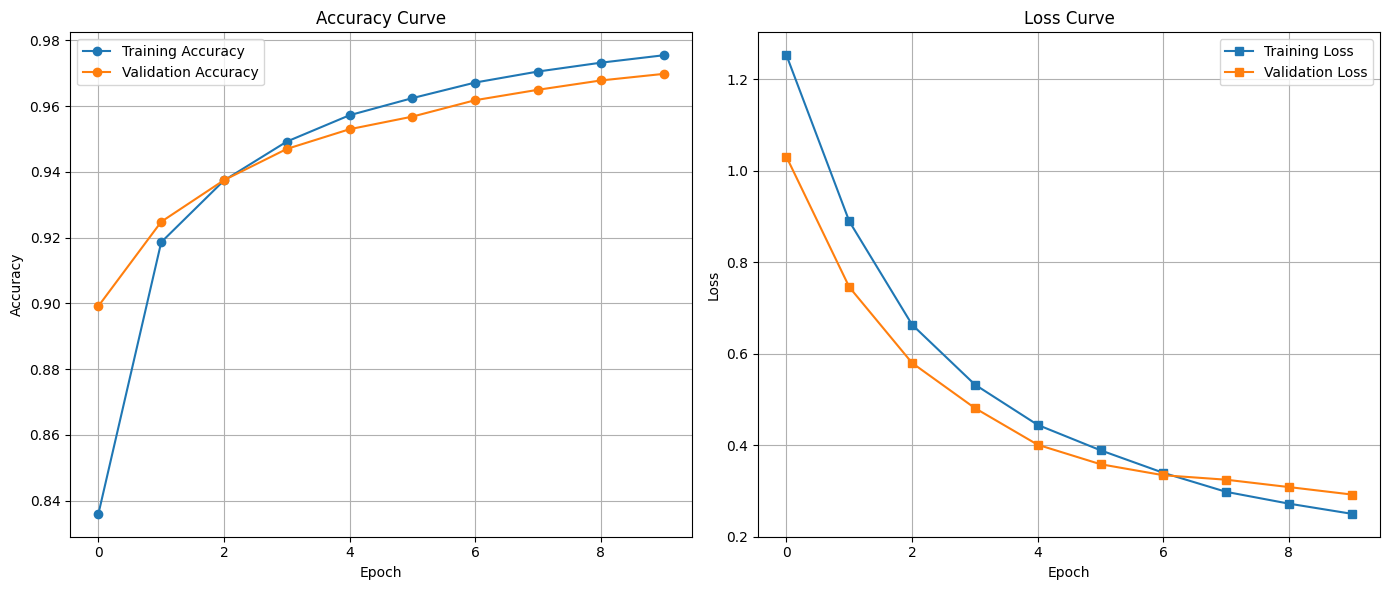

In [13]:
import matplotlib.pyplot as plt

# 假設 train_loss, train_acc, valid_loss, valid_acc 已經從 train 函式中獲取

# 創建一個圖形畫布，其中包含兩個子圖 (1 行 2 列)，並設定整個圖的大小
plt.figure(figsize=(14, 6))

#Accuracy
plt.subplot(1, 2, 1) # (總行數, 總列數, 當前子圖編號)
plt.plot(train_acc, marker='o', linestyle='-', label='Training Accuracy')
plt.plot(valid_acc, marker='o', linestyle='-', label='Validation Accuracy')
plt.title('Accuracy Curve') # 設定子圖標題
plt.xlabel('Epoch')         # 設定 x 軸標籤
plt.ylabel('Accuracy')      # 設定 y 軸標籤
plt.grid(True)              # 顯示網格
plt.legend()                # 顯示圖例 (label)

#Loss
plt.subplot(1, 2, 2) # 切換到第二個子圖
plt.plot(train_loss, marker='s', linestyle='-', label='Training Loss')
plt.plot(valid_loss, marker='s', linestyle='-', label='Validation Loss')
plt.title('Loss Curve')     # 設定子圖標題
plt.xlabel('Epoch')         # 設定 x 軸標籤
plt.ylabel('Loss')          # 設定 y 軸標籤
plt.grid(True)              # 顯示網格
plt.legend()                # 顯示圖例

# 調整子圖之間的間距以避免標題重疊
plt.tight_layout()

# 顯示最終的圖形
plt.show()